In [230]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import integrate
import geopy.distance


import matplotlib.pyplot as plt
import seaborn as sns

# Data

In [231]:
df_sample_data = pd.read_csv('data/Sample_data1.csv')
df_sample_data.head()

,fa_flight_id,altitude,altitude_change,groundspeed,heading,latitude,longitude,timestamp,update_type
0,TLM116-1664732580-schedule-0836,7,C,168,209,13.89892,100.59713,2022-10-04T17:23:06Z,A
1,TLM116-1664732580-schedule-0836,11,C,184,209,13.88681,100.59015,2022-10-04T17:23:22Z,A
2,TLM116-1664732580-schedule-0836,17,C,183,209,13.87550,100.58374,2022-10-04T17:23:38Z,A
3,TLM116-1664732580-schedule-0836,21,C,198,247,13.86586,100.57333,2022-10-04T17:23:54Z,A
4,TLM116-1664732580-schedule-0836,24,C,220,259,13.86200,100.55725,2022-10-04T17:24:10Z,A


In [232]:
npd = pd.read_csv('data/ANP2.2_NPD_data.csv',delimiter=';')
npd.head()

,NPD_ID,Noise Metric,Op Mode,Power Setting,L_200ft,L_400ft,L_630ft,L_1000ft,L_2000ft,L_4000ft,L_6300ft,L_10000ft,L_16000ft,L_25000ft
0,2CF650,EPNL,A,10000.0,106.2,101.1,97.2,92.5,84.2,75.0,68.0,61.4,53.4,43.3
1,2CF650,EPNL,A,25000.0,109.8,105.1,101.5,97.3,90.3,82.0,76.0,70.0,62.7,53.9
2,2CF650,EPNL,D,25000.0,109.8,105.1,101.5,97.3,90.3,82.0,76.0,70.0,62.7,53.9
3,2CF650,EPNL,D,40000.0,113.0,108.6,105.2,101.5,95.6,88.2,83.1,77.5,70.8,63.3
4,2CF650,LAmax,A,10000.0,99.2,91.9,86.7,81.0,72.1,63.0,56.7,49.6,41.6,33.1


In [233]:
Aircraft = pd.read_csv('data/ANP2.2_Aircraft.csv',delimiter=';')
Aircraft = Aircraft[Aircraft['ACFT_ID'] == '737800']
Aircraft.head()

,ACFT_ID,Description,Engine Type,Number Of Engines,Weight Class,Owner Category,Max Gross Takeoff Weight (lb),Max Gross Landing Weight (lb),Max Landing Distance (ft),Max Sea Level Static Thrust (lb),Noise Chapter,NPD_ID,Power Parameter,Approach Spectral Class ID,Departure Spectral Class ID,Lateral Directivity Identifier
24,737800,Boeing 737-800 / CFM56-7B26,Jet,2,Large,Commercial,174200,146300,5435,26300,3,CF567B,CNT (lb),203,104,Wing


In [234]:
df_fix_point = pd.read_csv('data/ANP2.2_Default_fixed_point_profiles.csv',delimiter=';')
df_fix_point = df_fix_point[df_fix_point.ACFT_ID == "727200"]
df_fix_point = df_fix_point[df_fix_point['Stage Length'] == 1]
df_fix_point = df_fix_point.reset_index(drop=True)

df_fix_point

,ACFT_ID,Op Type,Profile_ID,Stage Length,Point Number,Distance (ft),Altitude AFE (ft),TAS (kt),Power Setting
0,727200,A,DEFAULT,1,1,-114487.0,6000.0,250.0,809.0
1,727200,A,DEFAULT,1,2,-57243.0,3000.0,142.0,4490.0
2,727200,A,DEFAULT,1,3,-28622.0,1500.0,142.0,4490.0
3,727200,A,DEFAULT,1,4,-19081.0,1000.0,142.0,4490.0
4,727200,A,DEFAULT,1,5,0.0,0.0,142.0,4490.0
5,727200,A,DEFAULT,1,6,406.0,0.0,142.0,4758.0
6,727200,A,DEFAULT,1,7,4060.0,0.0,30.0,1190.0
7,727200,D,DEFAULT,1,1,0.0,0.0,35.0,11895.0
8,727200,D,DEFAULT,1,2,5968.0,0.0,153.0,11895.0
9,727200,D,DEFAULT,1,3,13346.0,1000.0,153.0,11895.0


In [235]:
# df_sample_data_initial2 = pd.read_csv('data/df_sample_data_initial2.csv')
df_sample_data_initial2 = pd.read_csv('data/Sample_data2.csv')
df_sample_data_initial2['timestamp'] = pd.to_datetime(df_sample_data_initial2['timestamp'])
df_sample_data_initial2.head()


,Unnamed: 0,timestamp,altitude,groundspeed,heading,latitude,longitude,segment
0,0,2022-10-04 17:23:06,7.0,168.0,209.0,13.898920,100.597130,1
1,1,2022-10-04 17:23:14,9.0,176.0,209.0,13.892865,100.593640,1
2,2,2022-10-04 17:23:22,11.0,184.0,209.0,13.886810,100.590150,3
3,3,2022-10-04 17:23:30,14.0,183.5,209.0,13.881155,100.586945,3
4,4,2022-10-04 17:23:38,17.0,183.0,209.0,13.875500,100.583740,3


In [236]:
# df_sample_data2 = pd.read_csv('data/Sample_data2.csv')
# df_sample_data2

# Power setting

## initial

In [237]:
df_fix_poit_initial = df_fix_point[df_fix_point['Op Type'] == "A"]
df_fix_poit_initial

,ACFT_ID,Op Type,Profile_ID,Stage Length,Point Number,Distance (ft),Altitude AFE (ft),TAS (kt),Power Setting
0,727200,A,DEFAULT,1,1,-114487.0,6000.0,250.0,809.0
1,727200,A,DEFAULT,1,2,-57243.0,3000.0,142.0,4490.0
2,727200,A,DEFAULT,1,3,-28622.0,1500.0,142.0,4490.0
3,727200,A,DEFAULT,1,4,-19081.0,1000.0,142.0,4490.0
4,727200,A,DEFAULT,1,5,0.0,0.0,142.0,4490.0
5,727200,A,DEFAULT,1,6,406.0,0.0,142.0,4758.0
6,727200,A,DEFAULT,1,7,4060.0,0.0,30.0,1190.0


In [238]:
df__tmp = df_fix_poit_initial.copy().groupby('TAS (kt)').max()
df__tmp = df__tmp.reindex(df__tmp.index.union(df_sample_data_initial2.groundspeed.unique()))
df__tmp = df__tmp.interpolate(method='index',limit_direction='both',limit=30)
df__tmp = df__tmp.reindex(df_sample_data_initial2.groundspeed.unique())
df__tmp.reset_index(drop=False, inplace=True)
df__tmp.rename(columns={'TAS (kt)':'groundspeed'}, inplace=True)
df__tmp = df__tmp[['groundspeed', 'Power Setting']]
df__tmp

,groundspeed,Power Setting
0,168.000000,3807.314815
1,176.000000,3514.796296
2,184.000000,3222.277778
3,183.500000,3240.560185
4,183.000000,3258.842593
5,190.500000,2984.606481
6,198.000000,2710.370370
7,209.000000,2308.157407
8,220.000000,1905.944444
9,231.130435,1498.962158


In [239]:
df_sample_data_initial2 = df_sample_data_initial2.merge(df__tmp, how='left', on='groundspeed')
df_sample_data_initial2.head()

,Unnamed: 0,timestamp,altitude,groundspeed,heading,latitude,longitude,segment,Power Setting
0,0,2022-10-04 17:23:06,7.0,168.0,209.0,13.898920,100.597130,1,3807.314815
1,1,2022-10-04 17:23:14,9.0,176.0,209.0,13.892865,100.593640,1,3514.796296
2,2,2022-10-04 17:23:22,11.0,184.0,209.0,13.886810,100.590150,3,3222.277778
3,3,2022-10-04 17:23:30,14.0,183.5,209.0,13.881155,100.586945,3,3240.560185
4,4,2022-10-04 17:23:38,17.0,183.0,209.0,13.875500,100.583740,3,3258.842593


# L by power level

## initial

In [240]:
npd_initial = npd[npd['NPD_ID'] == 'CF567B']
npd_initial = npd_initial[npd_initial['Noise Metric'] == 'LAmax']
npd_initial = npd_initial[npd_initial['Op Mode'] == 'A']
npd_initial.set_index('Power Setting', inplace=True)
npd_initial

,NPD_ID,Noise Metric,Op Mode,L_200ft,L_400ft,L_630ft,L_1000ft,L_2000ft,L_4000ft,L_6300ft,L_10000ft,L_16000ft,L_25000ft
Power Setting,,,,,,,,,,,,,
3000.0,CF567B,LAmax,A,93.0,85.9,81.1,76.1,68.0,59.2,52.5,45.6,37.5,29.3
4000.0,CF567B,LAmax,A,93.6,86.5,81.7,76.6,68.7,59.9,53.4,46.6,37.8,29.7
5000.0,CF567B,LAmax,A,94.1,87.0,82.2,77.2,69.2,60.5,54.1,47.4,39.0,31.1
6000.0,CF567B,LAmax,A,94.6,87.5,82.7,77.6,69.7,61.1,54.7,48.1,40.4,32.9
7000.0,CF567B,LAmax,A,95.0,87.9,83.0,78.0,70.1,61.5,55.2,48.7,41.8,34.5


In [241]:
# df_sample_data_initial2['Power Setting'].unique()

In [242]:
npd_initial = npd_initial.reindex(npd_initial.index.union(df_sample_data_initial2['Power Setting'].unique()))
npd_initial = npd_initial.interpolate(method='index',limit_direction='both',limit=10)
npd_initial

,NPD_ID,Noise Metric,Op Mode,L_200ft,L_400ft,L_630ft,L_1000ft,L_2000ft,L_4000ft,L_6300ft,L_10000ft,L_16000ft,L_25000ft
Power Setting,,,,,,,,,,,,,
809.000000,NaN,NaN,NaN,93.000000,85.900000,81.100000,76.100000,68.000000,59.200000,52.500000,45.600000,37.500000,29.300000
1091.979871,NaN,NaN,NaN,93.000000,85.900000,81.100000,76.100000,68.000000,59.200000,52.500000,45.600000,37.500000,29.300000
1498.962158,NaN,NaN,NaN,93.000000,85.900000,81.100000,76.100000,68.000000,59.200000,52.500000,45.600000,37.500000,29.300000
1905.944444,NaN,NaN,NaN,93.000000,85.900000,81.100000,76.100000,68.000000,59.200000,52.500000,45.600000,37.500000,29.300000
2308.157407,NaN,NaN,NaN,93.000000,85.900000,81.100000,76.100000,68.000000,59.200000,52.500000,45.600000,37.500000,29.300000
2710.370370,NaN,NaN,NaN,93.000000,85.900000,81.100000,76.100000,68.000000,59.200000,52.500000,45.600000,37.500000,29.300000
2984.606481,NaN,NaN,NaN,93.000000,85.900000,81.100000,76.100000,68.000000,59.200000,52.500000,45.600000,37.500000,29.300000
3000.000000,CF567B,LAmax,A,93.000000,85.900000,81.100000,76.100000,68.000000,59.200000,52.500000,45.600000,37.500000,29.300000
3222.277778,NaN,NaN,NaN,93.133367,86.033367,81.233367,76.211139,68.155594,59.355594,52.700050,45.822278,37.566683,29.388911


# Aircraft

## distance

In [243]:
def add_distance(position1,lat, long):
    position1 = position1.split(",")
    # position2 = position2.split(",")
    position2 = (lat,long)
    return geopy.distance.geodesic(position1, position2).ft

In [244]:
observer = '13.89701111,100.5959389'

In [245]:
tmp_distance = []
df_sample_data_initial2['distance'] = -1
for index, row in df_sample_data_initial2.iterrows():
    distance = add_distance(observer, row['latitude'], row['longitude'])
    # print(distance)
    tmp_distance.append(distance)
    df_sample_data_initial2.loc[index, 'distance'] = distance
df_sample_data_initial2

,Unnamed: 0,timestamp,altitude,groundspeed,heading,latitude,longitude,segment,Power Setting,distance
0,0,2022-10-04 17:23:06,7.000000,168.000000,209.000000,13.898920,100.597130,1,3807.314815,811.481578
1,1,2022-10-04 17:23:14,9.000000,176.000000,209.000000,13.892865,100.593640,1,3514.796296,1711.583325
2,2,2022-10-04 17:23:22,11.000000,184.000000,209.000000,13.886810,100.590150,3,3222.277778,4233.810050
3,3,2022-10-04 17:23:30,14.000000,183.500000,209.000000,13.881155,100.586945,3,3240.560185,6580.144088
4,4,2022-10-04 17:23:38,17.000000,183.000000,209.000000,13.875500,100.583740,3,3258.842593,8926.490754
5,5,2022-10-04 17:23:46,19.000000,190.500000,228.000000,13.870680,100.578535,3,2984.606481,11377.294707
6,6,2022-10-04 17:23:54,21.000000,198.000000,247.000000,13.865860,100.573330,3,2710.370370,13861.472594
7,7,2022-10-04 17:24:02,22.500000,209.000000,253.000000,13.863930,100.565290,5,2308.157407,16196.413041
8,8,2022-10-04 17:24:10,24.000000,220.000000,259.000000,13.862000,100.557250,5,1905.944444,18701.557320
9,9,2022-10-04 17:24:18,25.739130,231.130435,257.608696,13.860073,100.548666,5,1498.962158,21466.711604


# interpolate 

## interpolate L

In [246]:
npd_initial

,NPD_ID,Noise Metric,Op Mode,L_200ft,L_400ft,L_630ft,L_1000ft,L_2000ft,L_4000ft,L_6300ft,L_10000ft,L_16000ft,L_25000ft
Power Setting,,,,,,,,,,,,,
809.000000,NaN,NaN,NaN,93.000000,85.900000,81.100000,76.100000,68.000000,59.200000,52.500000,45.600000,37.500000,29.300000
1091.979871,NaN,NaN,NaN,93.000000,85.900000,81.100000,76.100000,68.000000,59.200000,52.500000,45.600000,37.500000,29.300000
1498.962158,NaN,NaN,NaN,93.000000,85.900000,81.100000,76.100000,68.000000,59.200000,52.500000,45.600000,37.500000,29.300000
1905.944444,NaN,NaN,NaN,93.000000,85.900000,81.100000,76.100000,68.000000,59.200000,52.500000,45.600000,37.500000,29.300000
2308.157407,NaN,NaN,NaN,93.000000,85.900000,81.100000,76.100000,68.000000,59.200000,52.500000,45.600000,37.500000,29.300000
2710.370370,NaN,NaN,NaN,93.000000,85.900000,81.100000,76.100000,68.000000,59.200000,52.500000,45.600000,37.500000,29.300000
2984.606481,NaN,NaN,NaN,93.000000,85.900000,81.100000,76.100000,68.000000,59.200000,52.500000,45.600000,37.500000,29.300000
3000.000000,CF567B,LAmax,A,93.000000,85.900000,81.100000,76.100000,68.000000,59.200000,52.500000,45.600000,37.500000,29.300000
3222.277778,NaN,NaN,NaN,93.133367,86.033367,81.233367,76.211139,68.155594,59.355594,52.700050,45.822278,37.566683,29.388911


In [247]:
# npd_inter = npd.drop(columns=['NPD_ID','Noise Metric','Op Mode','Power Setting']).T.reset_index()
npd_inter = npd_initial.drop(columns=['NPD_ID','Noise Metric','Op Mode']).T.reset_index()
npd_inter.rename(columns={'index':'distance'},inplace=True)
npd_inter

Power Setting,distance,809.0,1091.9798711755247,1498.962157809984,1905.9444444444443,2308.1574074074074,2710.3703703703704,2984.6064814814813,3000.0,3222.2777777777774,3240.560185185185,3258.8425925925926,3514.7962962962965,3807.314814814815,4000.0,5000.0,6000.0,7000.0
0,L_200ft,93.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0,93.133367,93.144336,93.155306,93.308878,93.484389,93.6,94.1,94.6,95.0
1,L_400ft,85.9,85.9,85.9,85.9,85.9,85.9,85.9,85.9,86.033367,86.044336,86.055306,86.208878,86.384389,86.5,87.0,87.5,87.9
2,L_630ft,81.1,81.1,81.1,81.1,81.1,81.1,81.1,81.1,81.233367,81.244336,81.255306,81.408878,81.584389,81.7,82.2,82.7,83.0
3,L_1000ft,76.1,76.1,76.1,76.1,76.1,76.1,76.1,76.1,76.211139,76.220280,76.229421,76.357398,76.503657,76.6,77.2,77.6,78.0
4,L_2000ft,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.155594,68.168392,68.181190,68.360357,68.565120,68.7,69.2,69.7,70.1
5,L_4000ft,59.2,59.2,59.2,59.2,59.2,59.2,59.2,59.2,59.355594,59.368392,59.381190,59.560357,59.765120,59.9,60.5,61.1,61.5
6,L_6300ft,52.5,52.5,52.5,52.5,52.5,52.5,52.5,52.5,52.700050,52.716504,52.732958,52.963317,53.226583,53.4,54.1,54.7,55.2
7,L_10000ft,45.6,45.6,45.6,45.6,45.6,45.6,45.6,45.6,45.822278,45.840560,45.858843,46.114796,46.407315,46.6,47.4,48.1,48.7
8,L_16000ft,37.5,37.5,37.5,37.5,37.5,37.5,37.5,37.5,37.566683,37.572168,37.577653,37.654439,37.742194,37.8,39.0,40.4,41.8
9,L_25000ft,29.3,29.3,29.3,29.3,29.3,29.3,29.3,29.3,29.388911,29.396224,29.403537,29.505919,29.622926,29.7,31.1,32.9,34.5


In [248]:
def get_feet(distance):
    # print(distance)
    feet = distance.split('_')[1]
    return float(feet[:-2])
npd_inter['distance'] = npd_inter['distance'].apply(get_feet)
# npd_inter = npd_inter[['distance',0]]
# npd_inter = npd_inter[['distance',3000.0]]
npd_inter


Power Setting,distance,809.0,1091.9798711755247,1498.962157809984,1905.9444444444443,2308.1574074074074,2710.3703703703704,2984.6064814814813,3000.0,3222.2777777777774,3240.560185185185,3258.8425925925926,3514.7962962962965,3807.314814814815,4000.0,5000.0,6000.0,7000.0
0,200.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0,93.133367,93.144336,93.155306,93.308878,93.484389,93.6,94.1,94.6,95.0
1,400.0,85.9,85.9,85.9,85.9,85.9,85.9,85.9,85.9,86.033367,86.044336,86.055306,86.208878,86.384389,86.5,87.0,87.5,87.9
2,630.0,81.1,81.1,81.1,81.1,81.1,81.1,81.1,81.1,81.233367,81.244336,81.255306,81.408878,81.584389,81.7,82.2,82.7,83.0
3,1000.0,76.1,76.1,76.1,76.1,76.1,76.1,76.1,76.1,76.211139,76.220280,76.229421,76.357398,76.503657,76.6,77.2,77.6,78.0
4,2000.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.155594,68.168392,68.181190,68.360357,68.565120,68.7,69.2,69.7,70.1
5,4000.0,59.2,59.2,59.2,59.2,59.2,59.2,59.2,59.2,59.355594,59.368392,59.381190,59.560357,59.765120,59.9,60.5,61.1,61.5
6,6300.0,52.5,52.5,52.5,52.5,52.5,52.5,52.5,52.5,52.700050,52.716504,52.732958,52.963317,53.226583,53.4,54.1,54.7,55.2
7,10000.0,45.6,45.6,45.6,45.6,45.6,45.6,45.6,45.6,45.822278,45.840560,45.858843,46.114796,46.407315,46.6,47.4,48.1,48.7
8,16000.0,37.5,37.5,37.5,37.5,37.5,37.5,37.5,37.5,37.566683,37.572168,37.577653,37.654439,37.742194,37.8,39.0,40.4,41.8
9,25000.0,29.3,29.3,29.3,29.3,29.3,29.3,29.3,29.3,29.388911,29.396224,29.403537,29.505919,29.622926,29.7,31.1,32.9,34.5


In [249]:
npd_inter.set_index('distance',inplace=True)
npd_after_inter = npd_inter.reindex(npd_inter.index.union(tmp_distance))
npd_after_inter = npd_after_inter.interpolate(method='index',limit_direction='both',limit=6)
npd_after_inter


Power Setting,809.0,1091.9798711755247,1498.962157809984,1905.9444444444443,2308.1574074074074,2710.3703703703704,2984.6064814814813,3000.0,3222.2777777777774,3240.560185185185,3258.8425925925926,3514.7962962962965,3807.314814814815,4000.0,5000.0,6000.0,7000.0
distance,,,,,,,,,,,,,,,,,
200.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.133367,93.144336,93.155306,93.308878,93.484389,93.600000,94.100000,94.600000,95.000000
400.000000,85.900000,85.900000,85.900000,85.900000,85.900000,85.900000,85.900000,85.900000,86.033367,86.044336,86.055306,86.208878,86.384389,86.500000,87.000000,87.500000,87.900000
630.000000,81.100000,81.100000,81.100000,81.100000,81.100000,81.100000,81.100000,81.100000,81.233367,81.244336,81.255306,81.408878,81.584389,81.700000,82.200000,82.700000,83.000000
811.481578,78.647546,78.647546,78.647546,78.647546,78.647546,78.647546,78.647546,78.647546,78.770010,78.780083,78.790156,78.931174,79.092337,79.198497,79.747546,80.198497,80.547546
1000.000000,76.100000,76.100000,76.100000,76.100000,76.100000,76.100000,76.100000,76.100000,76.211139,76.220280,76.229421,76.357398,76.503657,76.600000,77.200000,77.600000,78.000000
1711.583325,70.336175,70.336175,70.336175,70.336175,70.336175,70.336175,70.336175,70.336175,70.478948,70.490691,70.502434,70.666837,70.854727,70.978492,71.507333,71.978492,72.378492
2000.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.155594,68.168392,68.181190,68.360357,68.565120,68.700000,69.200000,69.700000,70.100000
4000.000000,59.200000,59.200000,59.200000,59.200000,59.200000,59.200000,59.200000,59.200000,59.355594,59.368392,59.381190,59.560357,59.765120,59.900000,60.500000,61.100000,61.500000
4233.810050,58.518901,58.518901,58.518901,58.518901,58.518901,58.518901,58.518901,58.518901,58.679015,58.692184,58.705354,58.889725,59.100435,59.239232,59.849398,60.449398,60.859564


In [250]:
model_data = npd_after_inter.copy()
model_data

Power Setting,809.0,1091.9798711755247,1498.962157809984,1905.9444444444443,2308.1574074074074,2710.3703703703704,2984.6064814814813,3000.0,3222.2777777777774,3240.560185185185,3258.8425925925926,3514.7962962962965,3807.314814814815,4000.0,5000.0,6000.0,7000.0
distance,,,,,,,,,,,,,,,,,
200.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.133367,93.144336,93.155306,93.308878,93.484389,93.600000,94.100000,94.600000,95.000000
400.000000,85.900000,85.900000,85.900000,85.900000,85.900000,85.900000,85.900000,85.900000,86.033367,86.044336,86.055306,86.208878,86.384389,86.500000,87.000000,87.500000,87.900000
630.000000,81.100000,81.100000,81.100000,81.100000,81.100000,81.100000,81.100000,81.100000,81.233367,81.244336,81.255306,81.408878,81.584389,81.700000,82.200000,82.700000,83.000000
811.481578,78.647546,78.647546,78.647546,78.647546,78.647546,78.647546,78.647546,78.647546,78.770010,78.780083,78.790156,78.931174,79.092337,79.198497,79.747546,80.198497,80.547546
1000.000000,76.100000,76.100000,76.100000,76.100000,76.100000,76.100000,76.100000,76.100000,76.211139,76.220280,76.229421,76.357398,76.503657,76.600000,77.200000,77.600000,78.000000
1711.583325,70.336175,70.336175,70.336175,70.336175,70.336175,70.336175,70.336175,70.336175,70.478948,70.490691,70.502434,70.666837,70.854727,70.978492,71.507333,71.978492,72.378492
2000.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.000000,68.155594,68.168392,68.181190,68.360357,68.565120,68.700000,69.200000,69.700000,70.100000
4000.000000,59.200000,59.200000,59.200000,59.200000,59.200000,59.200000,59.200000,59.200000,59.355594,59.368392,59.381190,59.560357,59.765120,59.900000,60.500000,61.100000,61.500000
4233.810050,58.518901,58.518901,58.518901,58.518901,58.518901,58.518901,58.518901,58.518901,58.679015,58.692184,58.705354,58.889725,59.100435,59.239232,59.849398,60.449398,60.859564


In [251]:
for index, row in df_sample_data_initial2.iterrows():
    df_sample_data_initial2.loc[index,'sound'] = model_data.loc[row.distance,row['Power Setting']]
    # print(model_data.loc[row.distance,row['Power Setting']])
    
df_sample_data_initial2.head()

,Unnamed: 0,timestamp,altitude,groundspeed,heading,latitude,longitude,segment,Power Setting,distance,sound
0,0,2022-10-04 17:23:06,7.0,168.0,209.0,13.898920,100.597130,1,3807.314815,811.481578,79.092337
1,1,2022-10-04 17:23:14,9.0,176.0,209.0,13.892865,100.593640,1,3514.796296,1711.583325,70.666837
2,2,2022-10-04 17:23:22,11.0,184.0,209.0,13.886810,100.590150,3,3222.277778,4233.810050,58.679015
3,3,2022-10-04 17:23:30,14.0,183.5,209.0,13.881155,100.586945,3,3240.560185,6580.144088,52.195895
4,4,2022-10-04 17:23:38,17.0,183.0,209.0,13.875500,100.583740,3,3258.842593,8926.490754,47.853282


In [252]:
df_35a = df_sample_data_initial2.copy()

# Model

## Single event sound 

In [253]:
df_single_event_sound = pd.DataFrame(columns=['segment','area','t0'])
# sound_exposure = pd.DataFrame(columns=['sound'])

In [254]:
df_sample_data_initial2['T'] =-1
for index, row in df_sample_data_initial2.iterrows():
    df_sample_data_initial2.loc[index,'T'] = (row['timestamp']-df_sample_data_initial2.iloc[0]['timestamp'])/np.timedelta64(1,'s')

df_sample_data_initial2.head()

,Unnamed: 0,timestamp,altitude,groundspeed,heading,latitude,longitude,segment,Power Setting,distance,sound,T
0,0,2022-10-04 17:23:06,7.0,168.0,209.0,13.898920,100.597130,1,3807.314815,811.481578,79.092337,0
1,1,2022-10-04 17:23:14,9.0,176.0,209.0,13.892865,100.593640,1,3514.796296,1711.583325,70.666837,8
2,2,2022-10-04 17:23:22,11.0,184.0,209.0,13.886810,100.590150,3,3222.277778,4233.810050,58.679015,16
3,3,2022-10-04 17:23:30,14.0,183.5,209.0,13.881155,100.586945,3,3240.560185,6580.144088,52.195895,24
4,4,2022-10-04 17:23:38,17.0,183.0,209.0,13.875500,100.583740,3,3258.842593,8926.490754,47.853282,32


In [255]:
df_sample_data_initial2 = df_sample_data_initial2.groupby('segment').mean()
df_sample_data_initial2 = df_sample_data_initial2[df_sample_data_initial2.sound.notnull()]
df_sample_data_initial2

,Unnamed: 0,altitude,groundspeed,heading,latitude,longitude,Power Setting,distance,sound,T
segment,,,,,,,,,,
1,0.5,8.000000,172.000000,209.000000,13.895893,100.595385,3661.055556,1261.532451,74.879587,4.0
3,4.0,16.400000,187.800000,220.400000,13.876001,100.582540,3083.331481,8995.842439,48.571171,32.0
5,9.5,26.323269,234.602254,255.952496,13.859452,100.545864,1403.840647,22475.223680,32.233242,74.5
7,17.5,40.099206,278.903968,242.192063,13.839660,100.489944,809.000000,42976.734517,29.300000,122.3


In [256]:
def function_L(sound) :
    return 10**(sound / 10)

# model_data['Function'] = model_data['sound'].apply(function_L)
df_sample_data_initial2['Function'] = df_sample_data_initial2['sound'].apply(function_L)
# model_data
df_sample_data_initial2.head()

,Unnamed: 0,altitude,groundspeed,heading,latitude,longitude,Power Setting,distance,sound,T,Function
segment,,,,,,,,,,,
1,0.5,8.000000,172.000000,209.000000,13.895893,100.595385,3661.055556,1261.532451,74.879587,4.0,3.075804e+07
3,4.0,16.400000,187.800000,220.400000,13.876001,100.582540,3083.331481,8995.842439,48.571171,32.0,7.196430e+04
5,9.5,26.323269,234.602254,255.952496,13.859452,100.545864,1403.840647,22475.223680,32.233242,74.5,1.672339e+03
7,17.5,40.099206,278.903968,242.192063,13.839660,100.489944,809.000000,42976.734517,29.300000,122.3,8.511380e+02


In [257]:
area = integrate.simpson(df_sample_data_initial2['Function'], df_sample_data_initial2['T'])
area

305275786.2695516

In [258]:
lSEL= 10*np.log10( (1/1)*area)
lSEL

84.8469235848616

In [259]:
# def integrate_single_event(data) :
#     global df_single_event_sound 
    
#     segment = data['segment'].max()
#     # area = integrate.simpson(data['Function'], data.index)
#     area = integrate.simpson(data['Function'], data['T'])
#     t0 = (data['timestamp'].iloc[-1] - data['timestamp'].iloc[0])/np.timedelta64(1,'s')
#     if (t0 == 0 or area != area):
#         return
#     else:
#         df_single_event_sound = df_single_event_sound.append({'segment':segment, 'area':area, 't0':t0}, ignore_index=True)

In [260]:
# for i in df_sample_data_initial2.segment.unique():
#     integrate_single_event(df_sample_data_initial2[df_sample_data_initial2.segment == i])


In [261]:
# area = integrate.simpson(df_sample_data_initial2['Function'], df_sample_data_initial2['T'])
# area

In [262]:
# sound_exposure['sound'] = 10*np.log10( (1/df_single_event_sound['t0'])*df_single_event_sound['area'] )
# sound_exposure['sound'] = 10*np.log10( (1/1)*df_single_event_sound['area'] )
# lSEL= 10*np.log10( (1/1)*area)
# sound_exposure
# lSEL

## Single sound event Lmax

## Decibel Addition and Subtraction

In [263]:
# sound_exposure = 10*np.log10( df_sample_data_initial2[~df_sample_data_initial2['sound'].isnull()].sum() )
# sound_exposure

In [264]:
# model_data

## Calculation of Cumulative Levels

In [265]:
# tmp = sound_exposure.copy()
# tmp

In [266]:
# Delta_i = 0
# gi = 10**(Delta_i / 10)
# t0 = 1
# T0 = 1

In [267]:
# def Cumulative_model(sound):
#     return 10**( sound / 10 )

# tmp['exponent'] = tmp['sound'].apply(Cumulative_model)

In [268]:
# 10*np.log10( (t0 / T0) * tmp['exponent'].sum() )

## LAE (3-5a)

In [269]:
df_35a.head()

,Unnamed: 0,timestamp,altitude,groundspeed,heading,latitude,longitude,segment,Power Setting,distance,sound
0,0,2022-10-04 17:23:06,7.0,168.0,209.0,13.898920,100.597130,1,3807.314815,811.481578,79.092337
1,1,2022-10-04 17:23:14,9.0,176.0,209.0,13.892865,100.593640,1,3514.796296,1711.583325,70.666837
2,2,2022-10-04 17:23:22,11.0,184.0,209.0,13.886810,100.590150,3,3222.277778,4233.810050,58.679015
3,3,2022-10-04 17:23:30,14.0,183.5,209.0,13.881155,100.586945,3,3240.560185,6580.144088,52.195895
4,4,2022-10-04 17:23:38,17.0,183.0,209.0,13.875500,100.583740,3,3258.842593,8926.490754,47.853282


In [270]:
Lmax = df_35a['sound'].max()

Le = df_35a[df_35a.sound > Lmax-10]
te = (Le['timestamp'].iloc[-1]-Le['timestamp'].iloc[0])/np.timedelta64(1,'s')

t0 = 1

In [271]:
Lmax + 10*( np.log10(te/t0) )

88.1232369540095

In [272]:
# Lmax + 10*( np.log10(te/10) )


# plot

In [273]:
df_sample_data_initial2.head()

,Unnamed: 0,altitude,groundspeed,heading,latitude,longitude,Power Setting,distance,sound,T,Function
segment,,,,,,,,,,,
1,0.5,8.000000,172.000000,209.000000,13.895893,100.595385,3661.055556,1261.532451,74.879587,4.0,3.075804e+07
3,4.0,16.400000,187.800000,220.400000,13.876001,100.582540,3083.331481,8995.842439,48.571171,32.0,7.196430e+04
5,9.5,26.323269,234.602254,255.952496,13.859452,100.545864,1403.840647,22475.223680,32.233242,74.5,1.672339e+03
7,17.5,40.099206,278.903968,242.192063,13.839660,100.489944,809.000000,42976.734517,29.300000,122.3,8.511380e+02


<AxesSubplot:xlabel='T', ylabel='sound'>

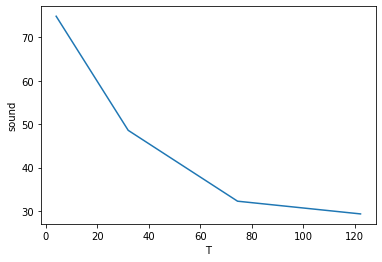

In [274]:
sns.lineplot(data=df_sample_data_initial2, x='T', y='sound')

Text(0, 0.5, 'Noise Level(dB)')

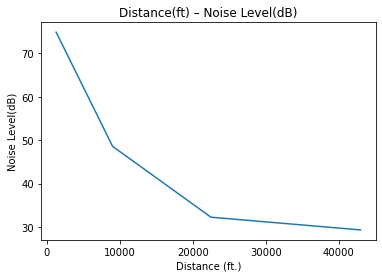

In [275]:
g1 = sns.lineplot(data=df_sample_data_initial2, x='distance', y='sound')
g1.set(title='Distance(ft) – Noise Level(dB)')
g1.set_xlabel("Distance (ft.)")
g1.set_ylabel("Noise Level(dB)")